#  настройка алгоритма

Автор: Никоноров Е.Н.
Дата: 24.11.2022
Курс: Аналитик данных (Data scientist) 2022
Кейс: №3 «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

Искомые параметры: 
1.Width
2.Depth


Описание файла:
1. Загружаем данные из initail, merged, generated 
2. Формируем X, y 
3. Разделяем на обучающую и тестовую выборки
4. Поиск лучших параметров для выбранного метода
5. Де-нормирование
6. Сохранение модели для использования на практике

In [18]:
#импорт библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
#загрузка данных
df_merged = pd.read_excel("../Data/ds_merged.xlsx ")
df_merged = df_merged.drop(['Unnamed: 0'], axis =1)

df_initial = pd.read_excel("../Data/ds_initial.xlsx ")
df_initial = df_initial.drop(['Unnamed: 0'], axis =1)

df_generated = pd.read_excel("../Data/ds_generated.xlsx ")
df_generated = df_generated.drop(['Unnamed: 0'], axis =1)

In [3]:
#менять датасет тут
df = df_merged

X=df.iloc[:,:4].to_numpy()
y=df.iloc[:,4:].to_numpy()

#
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [4]:

def plot_result(y_train,y_train_pred, y_test, y_pred):
    fig,axs = plt.subplots(figsize=(16,4), ncols=3)
    axs[0].scatter(y_train, y_train_pred)
    axs[0].set_title('train data')

    axs[1].scatter(y_pred, y_test, label="test data")
    axs[1].set_title('test data')
    err=y_pred - y_test
    axs[2].scatter(err[:,0], err[:,1], label="error")
    axs[2].set_title('error (test)')

    print('mse', mean_squared_error(y_test,y_pred))
    print('mae', mean_absolute_error(y_test,y_pred))
    print('Coef of determination', r2_score(y_test,y_pred))
    #reg.score(X_test, y_test)

    #((y_test-y_pred) ** 2).mean()

# Random Forest

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Random Search with Cross Validation

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 3, 4, 5],
 'n_estimators': [100, 111, 122, 133, 144, 155, 166, 177, 188, 200]}


In [7]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 200, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X, y);

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [8]:
rf_random.best_params_

{'n_estimators': 122,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [9]:
#rf_random.cv_results_

mse 0.004539368167138644
mae 0.04895267055066084
Coef of determination 0.917531178849477


array([0.91142722, 0.87960385, 0.8370675 , 0.86567989, 0.89749027,
       0.90092013, 0.90020432, 0.85013895, 0.87956389, 0.891997  ])

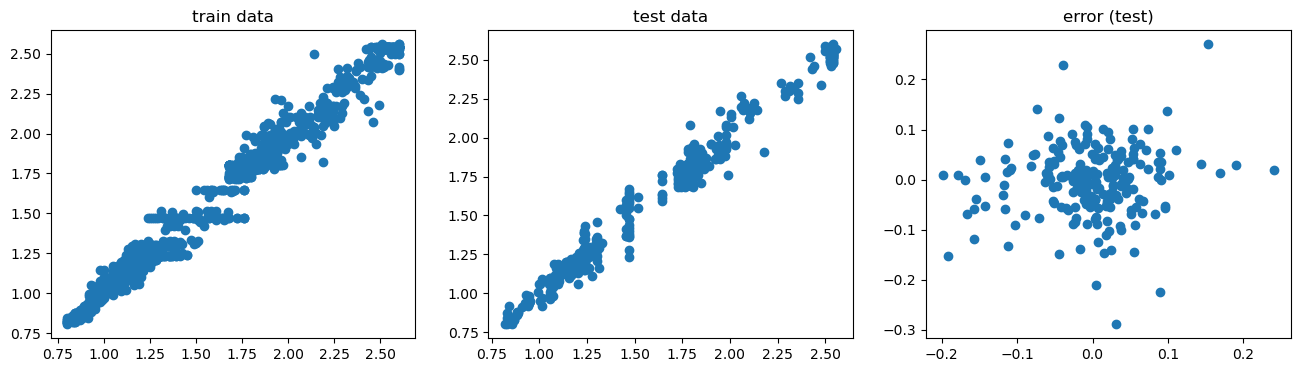

In [27]:
rf_final = RandomForestRegressor(
    random_state=0,
    n_estimators=122, 
    min_samples_split =3,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    max_depth=10,
    bootstrap = True)

reg = rf_final.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)
plot_result(y_train,y_train_pred, y_test, y_pred)

cross_val_score(reg, X, y, cv=10)

# for rs in range(1000, 2000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = rs)
    rf_final = RandomForestRegressor(
        random_state=0,
        n_estimators=100, 
        min_samples_split =2,
        min_samples_leaf = 1,
        max_features = 'auto',
        max_depth=20,
        bootstrap = True)

    reg = rf_final.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    y_pred = reg.predict(X_test)
    print('rs:', rs)
    print('Cd:', r2_score(y_test,y_pred))
        

# Вывод

Изменение параметров алгоритма в широком диапазоне (несколько тысяч экспериментов) не позволили существенно увеличить качество алгоритма относительно параметров из документации.

Наибольший эффект на "качество" оказывает случайное разбиение на Train\Test

для инит датасета наилучший результат 0.967 (Coeff of determination)

для merged датасета(+сгенерированные данные) наилучший вариант 0.91 при randomState 448, 1456 и тп

по статистике, результат находится в диапазоне между 0.8 и 0.9 в зависимости от разбиения Train\Test

mse 0.005036540668760902
mae 0.050294112615585654
Coef of determination 0.9109024739572591


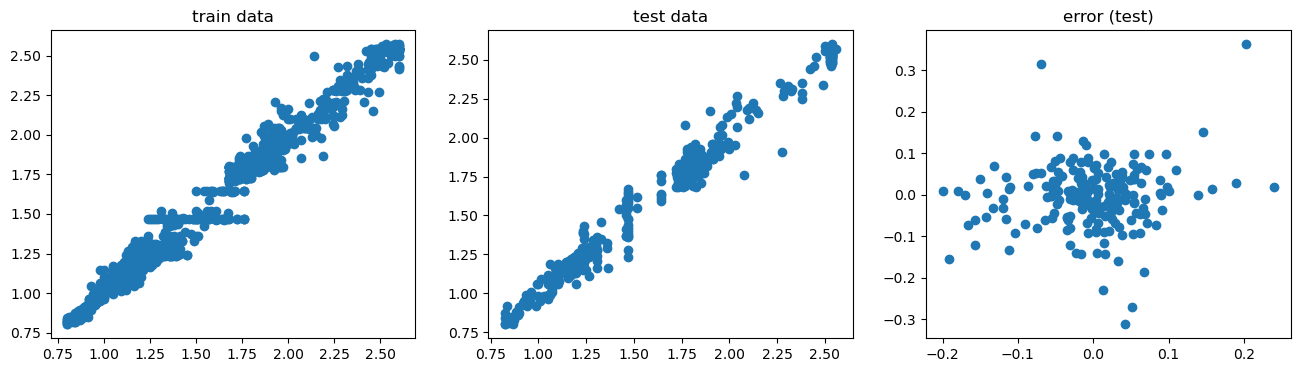

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 448)
rf_final = RandomForestRegressor(
        random_state=0,
        n_estimators=100, 
        min_samples_split =2,
        min_samples_leaf = 1,
        max_features = 'auto',
        max_depth=20,
        bootstrap = True)

reg = rf_final.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)
plot_result(y_train,y_train_pred, y_test, y_pred)

# Сохранение модели
сохраняем в папку Saved models

In [12]:
import pickle

In [13]:
with open('../Saved models/rf_model_pkl.pkl', 'wb') as f:
    pickle.dump(reg,f)

In [14]:
!pip freeze > requirements.txt